In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 1024 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


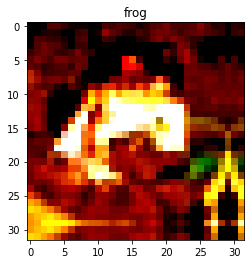

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine-batch1024-lr02.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.2
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 2.480867466148065, Test loss 1.6084054708480835, Train accuracy 25.30759655699438, Test accuracy 40.86654968261719, Cost 66.12045001983643 s
Epoch 2, Train loss 1.5675213872169962, Test loss 1.4092001914978027, Train accuracy 41.78852704106545, Test accuracy 48.56843872070313, Cost 75.98131775856018 s
Epoch 3, Train loss 1.369731294865511, Test loss 1.160453724861145, Train accuracy 50.2570574234943, Test accuracy 57.78400001525879, Cost 77.30067706108093 s
Epoch 4, Train loss 1.160936101358764, Test loss 0.9825152456760406, Train accuracy 58.10592005204181, Test accuracy 64.60020713806152, Cost 78.34022164344788 s
Epoch 5, Train loss 0.9812322453576692, Test loss 0.9157189011573792, Train accuracy 65.00375280574876, Test accuracy 66.9090805053711, Cost 79.76106452941895 s
Model saved in epoch 5
Epoch 6, Train loss 0.832957462388642, Test loss 0.6889289200305939, Train accuracy 70.6092667871592, Test accuracy 76.36639022827148, Cost 79.5491669178009 s
Epoch 7, Train

Epoch 50, Train loss 0.04066162275112405, Test loss 0.37574180364608767, Train accuracy 98.53782622668209, Test accuracy 91.60933532714844, Cost 103.44968152046204 s
Model saved in epoch 50
Epoch 51, Train loss 0.03607347847095558, Test loss 0.3528172940015793, Train accuracy 98.6936173730967, Test accuracy 91.92482452392578, Cost 102.5376706123352 s
Epoch 52, Train loss 0.03676925401906578, Test loss 0.36150566041469573, Train accuracy 98.69403091742068, Test accuracy 91.83175201416016, Cost 112.76360869407654 s
Epoch 53, Train loss 0.035804321913390745, Test loss 0.3618297666311264, Train accuracy 98.76893709143813, Test accuracy 91.6161117553711, Cost 113.93111777305603 s
Epoch 54, Train loss 0.034476914043937414, Test loss 0.3625932365655899, Train accuracy 98.81883706851882, Test accuracy 92.0336410522461, Cost 101.15182280540466 s
Epoch 55, Train loss 0.03472175608788218, Test loss 0.3764091730117798, Train accuracy 98.818009668467, Test accuracy 91.89772033691406, Cost 107.32955

Epoch 99, Train loss 0.011058896751504163, Test loss 0.4223070561885834, Train accuracy 99.63479505266461, Test accuracy 92.60762100219726, Cost 104.14441537857056 s
Epoch 100, Train loss 0.010547107479972194, Test loss 0.4155436336994171, Train accuracy 99.6532206632653, Test accuracy 92.71743392944336, Cost 105.33259773254395 s
Model saved in epoch 100
Epoch 101, Train loss 0.010274892748922718, Test loss 0.4295952469110489, Train accuracy 99.64524872448979, Test accuracy 92.61360015869141, Cost 102.78310489654541 s
Epoch 102, Train loss 0.009397107209744198, Test loss 0.4354607701301575, Train accuracy 99.66634431177256, Test accuracy 92.7367660522461, Cost 100.86168622970581 s
Epoch 103, Train loss 0.008165792305478635, Test loss 0.43132707178592683, Train accuracy 99.71135555967993, Test accuracy 92.6518653869629, Cost 114.02414226531982 s
Epoch 104, Train loss 0.008814052217735015, Test loss 0.42960848212242125, Train accuracy 99.71410074039382, Test accuracy 92.33717346191406, C

Epoch 147, Train loss 0.0027572795563396446, Test loss 0.45376471877098085, Train accuracy 99.90433673469387, Test accuracy 92.83003845214844, Cost 100.75918054580688 s
Epoch 148, Train loss 0.002278051744167674, Test loss 0.4578291743993759, Train accuracy 99.92186005261479, Test accuracy 92.94264221191406, Cost 111.71932864189148 s
Epoch 149, Train loss 0.002049529208678144, Test loss 0.443411585688591, Train accuracy 99.93581094547194, Test accuracy 92.79695434570313, Cost 100.53491735458374 s
Epoch 150, Train loss 0.0022473473114327396, Test loss 0.4411633133888245, Train accuracy 99.94378288424745, Test accuracy 93.10347595214844, Cost 106.12267661094666 s
Model saved in epoch 150
Epoch 151, Train loss 0.0023901184399526716, Test loss 0.4657557964324951, Train accuracy 99.91828762755102, Test accuracy 92.89979248046875, Cost 101.80067324638367 s
Epoch 152, Train loss 0.0022575376310019885, Test loss 0.4660421282052994, Train accuracy 99.94419642857143, Test accuracy 93.00203247070

Epoch 195, Train loss 0.0001941512827939658, Test loss 0.4524931162595749, Train accuracy 99.99800701530613, Test accuracy 93.61786499023438, Cost 100.87918853759766 s
Model saved in epoch 195
Epoch 196, Train loss 0.00014494008599063, Test loss 0.4546909540891647, Train accuracy 99.99759347098214, Test accuracy 93.51422958374023, Cost 105.9982967376709 s
Epoch 197, Train loss 0.0002682450054375555, Test loss 0.4580709159374237, Train accuracy 99.99202806122449, Test accuracy 93.45643310546875, Cost 104.93834042549133 s
Epoch 198, Train loss 0.00027563141624601224, Test loss 0.45934773087501524, Train accuracy 99.99402104591837, Test accuracy 93.50745391845703, Cost 108.4655511379242 s
Epoch 199, Train loss 0.0002159635432133432, Test loss 0.4639563262462616, Train accuracy 99.99601403061224, Test accuracy 93.40760498046875, Cost 105.3255045413971 s
Epoch 200, Train loss 0.00020805903659493197, Test loss 0.46026453375816345, Train accuracy 99.99800701530613, Test accuracy 93.5142295837

Epoch 244, Train loss 9.463266320492447e-05, Test loss 0.47050257921218874, Train accuracy 99.99800701530613, Test accuracy 93.55329208374023, Cost 105.34044814109802 s
Epoch 245, Train loss 7.496872063823002e-05, Test loss 0.468942129611969, Train accuracy 99.99800701530613, Test accuracy 93.54352645874023, Cost 108.89057278633118 s
Model saved in epoch 245
Epoch 246, Train loss 7.445121847774075e-05, Test loss 0.4686789631843567, Train accuracy 100.0, Test accuracy 93.42633895874023, Cost 100.42278957366943 s
Epoch 247, Train loss 9.207283020092588e-05, Test loss 0.4696189433336258, Train accuracy 99.99800701530613, Test accuracy 93.48792266845703, Cost 101.4241874217987 s
Epoch 248, Train loss 6.912933190041982e-05, Test loss 0.4705010414123535, Train accuracy 99.99800701530613, Test accuracy 93.58856811523438, Cost 108.4107506275177 s
Epoch 249, Train loss 8.55313107737801e-05, Test loss 0.47119430303573606, Train accuracy 99.99800701530613, Test accuracy 93.4917091369629, Cost 102

Epoch 295, Train loss 2.0924020093713936e-05, Test loss 0.47970953583717346, Train accuracy 100.0, Test accuracy 93.75458374023438, Cost 104.510568857193 s
Model saved in epoch 295
Epoch 296, Train loss 4.680344633869732e-05, Test loss 0.47693868577480314, Train accuracy 99.99800701530613, Test accuracy 93.74780807495117, Cost 108.61369633674622 s
Epoch 297, Train loss 2.6577246439863264e-05, Test loss 0.47520566284656524, Train accuracy 100.0, Test accuracy 93.71552124023438, Cost 101.55430221557617 s
Epoch 298, Train loss 2.2408622814454042e-05, Test loss 0.47476458847522734, Train accuracy 100.0, Test accuracy 93.73505249023438, Cost 102.44434237480164 s
Epoch 299, Train loss 2.8642898449069602e-05, Test loss 0.4752130687236786, Train accuracy 100.0, Test accuracy 93.72229766845703, Cost 100.26559281349182 s
Epoch 300, Train loss 3.7217133653104276e-05, Test loss 0.4761445790529251, Train accuracy 100.0, Test accuracy 93.74182891845703, Cost 106.25244688987732 s
Model saved in epoch

Epoch 346, Train loss 1.7959428852955913e-05, Test loss 0.4738304644823074, Train accuracy 100.0, Test accuracy 93.79364624023438, Cost 109.07911801338196 s
Epoch 347, Train loss 1.7080410042562644e-05, Test loss 0.4738344341516495, Train accuracy 100.0, Test accuracy 93.83270874023438, Cost 103.27565574645996 s
Epoch 348, Train loss 1.3258928517216748e-05, Test loss 0.47399761974811555, Train accuracy 100.0, Test accuracy 93.82294311523438, Cost 107.18881154060364 s
Epoch 349, Train loss 1.659815037950169e-05, Test loss 0.4739364147186279, Train accuracy 100.0, Test accuracy 93.80341186523438, Cost 100.14332675933838 s
Epoch 350, Train loss 1.9079393143551803e-05, Test loss 0.4742175817489624, Train accuracy 100.0, Test accuracy 93.81317749023438, Cost 109.60080528259277 s
Model saved in epoch 350
Epoch 351, Train loss 2.5259134983979476e-05, Test loss 0.47395637035369875, Train accuracy 100.0, Test accuracy 93.79364624023438, Cost 105.78279113769531 s
Epoch 352, Train loss 1.70656194

Epoch 397, Train loss 2.4326579835230534e-05, Test loss 0.47539404928684237, Train accuracy 100.0, Test accuracy 93.80341186523438, Cost 101.10660719871521 s
Epoch 398, Train loss 3.1548207491085826e-05, Test loss 0.47601031363010404, Train accuracy 100.0, Test accuracy 93.82294311523438, Cost 100.9939033985138 s
Epoch 399, Train loss 1.548767467079879e-05, Test loss 0.47601772248744967, Train accuracy 100.0, Test accuracy 93.83270874023438, Cost 100.2912027835846 s
Epoch 400, Train loss 1.4883071218941858e-05, Test loss 0.4760116428136826, Train accuracy 100.0, Test accuracy 93.82294311523438, Cost 101.05442976951599 s
Model saved in epoch 400
Epoch 401, Train loss 1.548270842602283e-05, Test loss 0.4761355400085449, Train accuracy 100.0, Test accuracy 93.82294311523438, Cost 101.09283947944641 s
Epoch 402, Train loss 1.3404990210931698e-05, Test loss 0.4761530041694641, Train accuracy 100.0, Test accuracy 93.82294311523438, Cost 111.37955737113953 s
Epoch 403, Train loss 3.6489503437

Epoch 448, Train loss 1.2952953673967776e-05, Test loss 0.47671211659908297, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 107.46514320373535 s
Epoch 449, Train loss 1.1509020484426197e-05, Test loss 0.47671560347080233, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 102.92150044441223 s
Epoch 450, Train loss 1.8524193805836946e-05, Test loss 0.4767272412776947, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 101.80438899993896 s
Model saved in epoch 450
Epoch 451, Train loss 1.4473970451239884e-05, Test loss 0.47675842642784116, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 106.42986011505127 s
Epoch 452, Train loss 1.4428668933129413e-05, Test loss 0.47675481140613557, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 106.2102279663086 s
Epoch 453, Train loss 1.5644290062148367e-05, Test loss 0.4767550677061081, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 100.99776482582092 s
Epoch 454, Train loss 2.106105

Epoch 499, Train loss 1.3670864091738845e-05, Test loss 0.4768868684768677, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 104.55762028694153 s
Epoch 500, Train loss 1.443683902612158e-05, Test loss 0.4768893957138062, Train accuracy 100.0, Test accuracy 93.84247436523438, Cost 104.98382592201233 s
Model saved in epoch 500


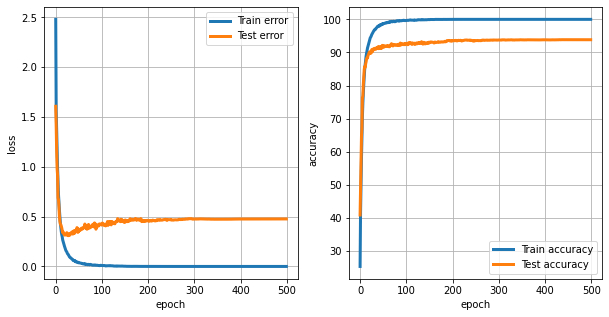

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 93.84247436523438
